In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize

Here, we compare the results of calculated heralding efficiency from spdcalc and the methods used in Ryan Bennink's paper. These calculations are based on a parameter related to focusing for each of the photons,

$$ \xi_j = \frac{L}{k_jw_j^2}, $$

where $w_j$ is the waist size for a given photon. 

We calculate heralding efficiency by considering

$$ P_{si} \approx \frac{64\pi^3\hbar c \epsilon n_s n_i}{\epsilon_0 n_p |n_s'-n_i'|} \left( \frac{\chi^{(2)}_{\textrm{eff}}}{\lambda_s\lambda_i}  \right)^2\frac{\arctan(\xi)}{A_+B_+} N_p $$

and 

$$ P_{s} \approx \frac{64\pi^3\hbar c \epsilon n_s n_i}{\epsilon_0 n_p |n_s'-n_i'|} \left( \frac{\chi^{(2)}_{\textrm{eff}}}{\lambda_s\lambda_i}  \right)^2\frac{\arctan(\xi_s B_s/A_s)}{A_sB_s} N_p, $$

so that the heralding efficiency $\eta_i = P_{si}/P_s$ is

$$ \frac{\arctan(\xi)}{A_+B_+} \frac{A_s B_s}{\arctan(\frac{B_s}{A_s}\xi_s)} $$.

We begin by calculating the focusing parameter and the momentum of each photon, assuming that $\lambda_s=\lambda_i = 1550$ nm and that $\lambda_p = 775$ nm. 

In [14]:
lambda_p = 775e-9
lambda_s = 1550e-9
lambda_i = 1550e-9

theta = np.radians(90)

L = 2000e-6

KDP_o = [2.259276,13.005522,400,0.01008956,0.012942625]
KDP_e = [2.132668,3.2279924,400,0.008637494,0.012281043]

def axisIndex(wavelength, sellmeier):
    wavelength = wavelength*10**6
    n_1 = sellmeier[0]
    n_2 = sellmeier[1]*(wavelength**2)/((wavelength**2)-sellmeier[2])
    n_3 = sellmeier[3]/((wavelength**2)-sellmeier[4])
    return np.sqrt(n_1+n_2+n_3)

def refIndex(theta, phi, wavelength, fast):
    theta = np.radians(theta)
    s_x=np.sin(theta)*np.cos(phi)
    s_y=np.sin(theta)*np.sin(phi)
    s_z=np.cos(theta)
    n_x = n_y = axisIndex(wavelength,KDP_o)
    n_z = axisIndex(wavelength,KDP_e)
        
    b = (s_x**2)*((n_y**-2)+(n_z**-2))+(s_y**2)*((n_x**-2)+(n_z**-2))+(s_z**2)*((n_x**-2)+(n_y**-2))
    c = (s_x**2)*(n_y**-2)*(n_z**-2)+(s_y**2)*(n_x**-2)*(n_z**-2)+(s_z**2)*(n_x**-2)*(n_y**-2)
    if fast == True:
        x = (b+np.sqrt((b**2)-4*c))/2
    else:
        x = (b-np.sqrt((b**2)-4*c))/2
    return np.sqrt(1/x)

n_i = refIndex(theta, 0, lambda_i, False)
n_s = refIndex(theta, 0, lambda_s, True)
n_p = refIndex(theta, 0, lambda_p, True)

waist_s = 100e-6
waist_i = 100e-6
waist_p = 100e-6
waist = np.linspace(1e-6, 130e-6, 130)

k_p = 2*math.pi*n_p/lambda_p
k_s = 2*math.pi*n_i/lambda_s
k_i = 2*math.pi*n_s/lambda_i

dk = k_p-k_s-k_i

focus_s = L/(k_s*waist_s**2)
focus_i = L/(k_i*waist_i**2)
focus_p = L/(k_p*waist_p**2)

s_focus = L/(k_s*waist**2)
i_focus = L/(k_i*waist**2)

Next, construct a series of functions to calculate the parameters $A_+,\ B_+,\ A_s,\ B_s,\ \xi$ so that their results can be used as parameters in the heralding calculation function. We calculate these according to the following equations.

$$ A_+ = 1 + \frac{k_s}{k_p}\frac{\xi_s}{\xi_p} + \frac{k_i}{k_p} \frac{\xi_i}{\xi_p} $$

$$ B_+ = \left(1-\frac{\Delta k }{k_p}\right) \left(1 + \frac{k_s+\Delta k}{k_p-\Delta k} \frac{\xi_p}{\xi_s} + \frac{k_i+\Delta k}{k_p-\Delta k} \frac{\xi_p}{\xi_i} \right) $$

$$ \xi = \frac{B_+}{A_+}\frac{\xi_s\xi_i}{\xi_p} $$

$$ A_s = 2\sqrt{\left(1 + \frac{k_s}{k_p}\frac{\xi_s}{\xi_p}\right)\frac{k_i}{k_p}} $$

$$ B_s = 2\left(1 - \frac{k_s+ \Delta k}{k_p - \Delta k}\right) \sqrt{\left(1 + \frac{k_s+\Delta k}{k_p - \Delta k} \frac{\xi_p}{\xi_s}\right)\frac{k_i+\Delta k}{k_p - \Delta k}} $$

In [15]:
def A_plus(focus_s, focus_i, focus_p):
    a = 1 + (k_s*focus_s)/(k_p*focus_p) + (k_i*focus_i)/(k_p*focus_p)
    return a

def B_plus(focus_s, focus_i, focus_p):
    b = (1-dk/k_p)*(1+focus_p*(k_s+dk)/((k_p-dk)*focus_s)+focus_p*(k_i+dk)/((k_p-dk)*focus_i))
    return b

def focus_agg(focus_s, focus_i, focus_p):
    z = B_plus(focus_s, focus_i, focus_p)*focus_s*focus_i/(A_plus(focus_s,focus_i,focus_p)*focus_p)
    return z

def A_s(focus_s, focus_i, focus_p):
    a = 2 * np.sqrt( (1 + k_s*focus_s / (k_p*focus_p) ) *k_i/k_p )
    return a

def B_s(focus_s, focus_i, focus_p):
    b = 2 * (1-dk/k_p) * np.sqrt( ( 1 + (k_s+dk)*focus_p / ( (k_p-dk)*focus_s) ) * (k_i+dk)/(k_p-dk) )
    return b

def i_heralding(focus_s, focus_i, focus_p):
    a_s = A_s(focus_s, focus_i, focus_p)
    b_s = B_s(focus_s, focus_i, focus_p)
    a_plus = A_plus(focus_s, focus_i, focus_p)
    b_plus = B_plus(focus_s, focus_i, focus_p)
    focus = focus_agg(focus_s, focus_i, focus_p)
    i = np.arctan(focus) * a_s * b_s / (a_plus*b_plus * np.arctan(b_s*focus_s/a_s))
    return i

Use these results to calculate the signal heralding efficiency when the waist of all three photons is located at the center of the crystal and $100 \mu\textrm{m}$ in length. Compare this to spdcalc's idler heralding efficiency of 0.8887664272477852 for these values, with signal and idler waists not at the center of the crystal. 

In [16]:
print(i_heralding(focus_s, focus_i, focus_p))

0.8887656445272609


Then calculate the heralding efficiency when the pump waist is kept constant at $100 \mu\textrm{m}$ while the signal and idler waist is allowed to vary from 1 to 130 $\mu\textrm{m}$, and plot the results. These can be compared to  <a href="http://wellcaffeinated.net/spdcalc-ui/#/?cfg=eyJhdXRvQ2FsY1RoZXRhIjp0cnVlLMkVUGVyaW9kaWNQb2xpbmfQHkludGVncmF0aW9uTGltaXRzyCFzcGRDb25maWciOnsiY3J5c3RhbCI6IktEUF8xIiwicG1fdHlwZSI6IlR5cGUyX2VfZW8iLMgpX3TmAIo5MMoTcGhpIjrLEGxlbmd0aCI6MjAwyxZ0ZW1wZXJhdHVyZcQbLCJmaWJlcl9jb3Vw7AC%2FcHVtcF93YXZlyEY3NzXHFmJhbmR3aWTEFTUuM8gWd2Fpc3QiOjHEbMURc3BlY3RydW1fdGhyZXNob2xkIjowLjEsInNpZ25hbM1dMTU1MMkZ5wDbyhHoANnHD%2BsAgMxOyn%2FME19wb3Np5AF9IjotNjg3LjMyNTU4MDQ3NjIyMzgsImlkbGVy8wCLxhjqAIrGEOUAiTE4yRDuAIrITOoAicsS7QCINzYuNTIzNzI1OTg3NzI4MSwicOcCRF9w5QJFX2VuYWJsZWTpAY7GFsYmIjoyNzYuNDU0NDYyODMxNTIxMSwiYXBvZGl65QJnyj1mYWxz5AKLyxxmd2htIjoxNjAwfSwiaeoCnOoCi2xzX21pbiI6MTQ0NC42ODI0Njg0MTQzMDc2LMUcYXjEQDU1LjMxNzUzMTU4NTY5MjcsImxpyDg1Ny4yODIyMjAyNzgwNzQ0xhzGODcxLjg4MDI4MDMyNDc1ODTkAa56ZeUBMH19&panels=W3sidHlwZSI6ImhlcmFsZGluZy1jYWxjIiwic2V0dGluZ3MiOnt9fSzTKHYtd3POKCJjb21iaW5lZEpTSUxvZ1NjYWxlIjpmYWxzZSwieGF4acUlbWluIjoiYXV0byIsIm1heCI6MTMwLCJzdGVwcyI6MTB9LCJqc2lSZXNvbHV0aW9uIjrEH8QwVXBkYXRlIjp0cnVl7ACUUGFuZWxMb2FkZXL6ALnbJV0%3D" target="_blank">spdcalc's results.</a>

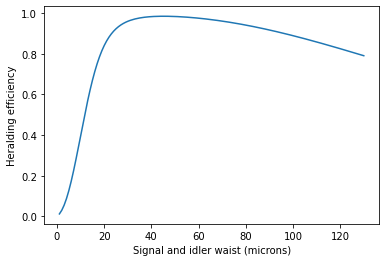

In [17]:
heralding_eff = i_heralding(s_focus, i_focus, focus_p)

plt.plot(waist*10**6, heralding_eff)
plt.xlabel("Signal and idler waist (microns)")
plt.ylabel("Heralding efficiency")
plt.show()

Next, consider a case where $k_s\approx k_i \approx k_p/2$ in order to calculate

$$ P_{s} \approx \frac{64\pi^3\hbar c \epsilon n_s n_i}{\epsilon_0 n_p |n_s'-n_i'|} \left( \frac{\chi^{(2)}_{\textrm{eff}}}{\lambda_s\lambda_i}  \right)^2\frac{\arctan(\xi_s B_s/A_s)}{A_sB_s} N_p.$$

Note that here $k_j = 2\pi n_j/\lambda_j$, which means that we can replace $n_j$ with $\lambda_k k_j/2\pi$ and rewrite this expression as

$$ P_{s} \approx \frac{32\pi^2\hbar c \epsilon k_s k_i}{\epsilon_0 k_p |n_s'-n_i'|} \frac{(\chi^{(2)}_{\textrm{eff}})^2}{\lambda_s\lambda_i\lambda_p}  \frac{\arctan(\xi_s B_s/A_s)}{A_sB_s} N_p.$$

Note that other than

$$ \frac{\arctan(\frac{B_s}{A_s}\xi_s)}{A_sB_s}, $$

all of these quantities are constants. Therefore, in order to plot this probability, we need only plot a normalized version of this equation to replicate figure 7 of Bennink's paper.

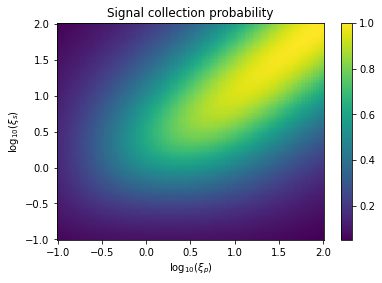

In [18]:
k_p = 2*math.pi/lambda_p
k_s = 2*math.pi/lambda_s
k_i = 2*math.pi/lambda_i
dk = 0

i_focus = p_focus = np.logspace(-1,2,num = 100, endpoint = True)

x_mesh,y_mesh = np.meshgrid(i_focus, p_focus)

def signal_prob(focus_s, focus_i, focus_p):
    a_s = A_s(focus_s, focus_i, focus_p)
    b_s = B_s(focus_s, focus_i, focus_p)
    p = np.arctan(focus_s*b_s/a_s)/(a_s*b_s)
    return p

def norm(array):
    prob_max = np.amax(array)
    return array/prob_max

p_s = norm(signal_prob(x_mesh, x_mesh, y_mesh))

plt.pcolormesh(np.log10(y_mesh), np.log10(x_mesh), p_s, shading = 'nearest')
cb = plt.colorbar()
plt.xlabel(r'log$_{10}(\xi_p$)')
plt.ylabel(r'log$_{10}(\xi_s)$')
plt.title('Signal collection probability')
plt.show()

We can also calculate the idler heralding efficiency in terms of waist size rather than focus in order to plot signal collection probability in terms of a more concrete physical parameter. Below, waist sizes are chosen so they will fall in a similar range to the equivalent range represented by the focusing parameter in the previous plot. 

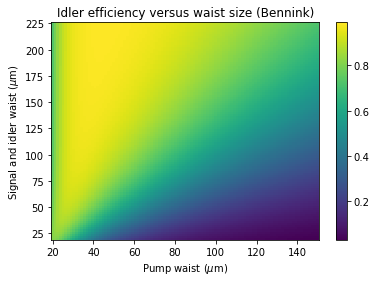

In [8]:
def to_focus(waist, k):
    focus = L/(k*waist**2)
    return focus

i_waist = np.linspace(20e-6, 225e-6, 100)
p_waist = np.linspace(20e-6, 150e-6, 100)

i_focus = to_focus(i_waist, k_i)
p_focus = to_focus(p_waist, k_p)

x_mesh, y_mesh = np.meshgrid(i_focus, p_focus)
idler_heralding = i_heralding(x_mesh, x_mesh, y_mesh)

plt.pcolormesh(p_waist*1e6, i_waist*1e6, idler_heralding, shading = 'nearest')
cb = plt.colorbar()
plt.xlabel(r'Pump waist ($\mu$m)')
plt.ylabel(r'Signal and idler waist ($\mu$m)')
plt.title('Idler efficiency versus waist size (Bennink)')
plt.show()

We can compare the results of this plot to those of the spdcalc library.

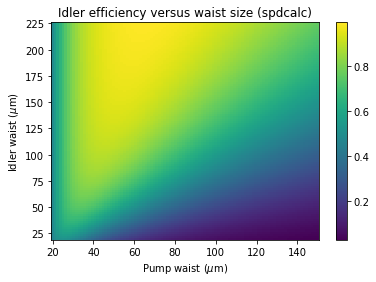

In [9]:
import spdcalc as spdc

lambda_s = lambda_i = 1550e-9
lambda_p = 775e-9

dim = 3
theta = np.radians(90)

setup = spdc.SPDCSetup.from_dict({
    "crystal": "KTP",
    "signal_wavelength": lambda_s, "pump_wavelength": lambda_p,
    "pm_type": "Type2_e_eo", "signal_waist": 0, "crystal_theta": theta
}, with_defaults=True)
setup.assign_optimum_periodic_poling()

ranges = spdc.plotting.calc_plot_config_for_jsi(setup, dim)

def signal_prob(p_waist, i_waist):
    setup = spdc.SPDCSetup.from_dict({
        "crystal": "KTP",
        "signal_wavelength": lambda_s, "pump_wavelength": lambda_p,
        "pm_type": "Type2_e_eo", "signal_waist": i_waist, "crystal_theta": theta,
        "idler_waist": i_waist, "pump_waist": p_waist
    }, with_defaults=True)
    setup.assign_optimum_periodic_poling()
    return spdc.plotting.calc_heralding_results(setup, ranges)['signal_efficiency']

points = 100

i_waist = np.linspace(20e-6, 225e-6, points)
p_waist = np.linspace(20e-6, 150e-6, points)
x_mesh, y_mesh = np.meshgrid(p_waist, i_waist)

p_s = np.zeros((points, points))

for i in range(points):
    for p in range(points):
        p_s[p][i] = signal_prob(p_waist[p], i_waist[i])
        
plt.pcolormesh(x_mesh*1e6, y_mesh*1e6, p_s, shading = 'nearest')
cb = plt.colorbar()
plt.xlabel(r'Pump waist ($\mu$m)')
plt.ylabel(r'Idler waist ($\mu$m)')
plt.title('Idler efficiency versus waist size (spdcalc)')
plt.show()

Next, for cases where $k_s\approx k_i \approx k_p/2$ we can optimize focusing parameters. We calculate $P_i$ in the same way that we calculate $P_s$, but with the indices switched. Since all other coefficients are constants, we set

$$ P_{si} = \frac{\arctan(\xi)}{A_+ B_+},$$

and we calculate the symmetric heralding using 

$$ \eta_{si} = \frac{P_{si}}{\sqrt{P_s P_i}}.$$

We can normalize the new probabilities in the same manner as we normalized $P_s$ above.

In [19]:
def A_i(focus_s, focus_i, focus_p):
    a = A_s(focus_i, focus_s, focus_p)
    return a

def B_i(focus_s, focus_i, focus_p):
    b = B_s(focus_i, focus_s, focus_p)
    return b

def idler_prob(focus_s, focus_i, focus_p):
    a_i = A_i(focus_s, focus_i, focus_p)
    b_i = B_i(focus_s, focus_i, focus_p)
    p = np.arctan(focus_i*b_i/a_i)/(a_i*b_i)
    return p

def pair_prob(focus_s, focus_i, focus_p):
    a_plus = A_plus(focus_s, focus_i, focus_p)
    b_plus = B_plus(focus_s, focus_i, focus_p)
    focus = focus_agg(focus_s, focus_i, focus_p)
    p = np.arctan(focus)/(a_plus*b_plus)
    return p

def symmetric_heralding(focus_s, focus_i, focus_p):
    p_s = signal_prob(focus_s, focus_i, focus_p)
    p_i = idler_prob(focus_s, focus_i, focus_p)
    p_si = pair_prob(focus_s, focus_i, focus_p)
    return p_si/np.sqrt(p_s*p_i)

Next, we use scipy to optimize the symmetric heralding for values of $\xi_p$ ranging from 0.01 to 100.

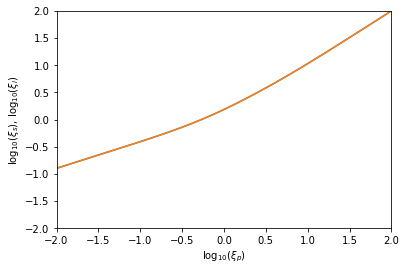

In [20]:
p_focus = np.logspace(-2,2,num = 130, endpoint = True)

x = 0.01

def p_fixed_symm(focus):
    focus_s, focus_i = focus
    return (-1)*symmetric_heralding(focus_s, focus_i, x)

signal = []
idler = []

for i in p_focus:
    x = i
    bnds = ((0.01*x, 100*x),(0.01*x, 100*x))
    opt = minimize(p_fixed_symm, (1e-10,1e-10), bounds = bnds)
    signal.append(opt['x'][0])
    idler.append(opt['x'][1])
    
plt.plot(np.log10(p_focus), np.log10(signal))
plt.plot(np.log10(p_focus), np.log10(idler))
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.ylabel(r'log$_{10}(\xi_s)$, log$_{10}(\xi_i)$')
plt.xlabel(r'log$_{10}(\xi_p)$')
plt.show()

Compare this plot to figure 8b of Bennink's paper. Next, we use these optimized values of $\xi_s$ and $\xi_i$ to plot the pair collection probability and the symmetric heralding efficiency, as shown in figure 8a of Bennink's paper. 

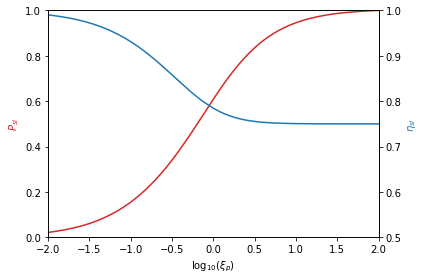

In [21]:
s_focus = np.array(signal)
i_focus = np.array(idler)

p_si = norm(pair_prob(s_focus, i_focus, p_focus))
symm_heralding = symmetric_heralding(s_focus, i_focus, p_focus)

# fig 8a
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel(r'log$_{10}(\xi_p$)')
ax1.set_xlim([-2,2])
ax1.set_ylim([0,1])
ax1.set_ylabel(r'$P_{si}$', color=color)
ax1.plot(np.log10(p_focus), p_si, color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(r'$\eta_{si}$', color=color)
ax2.set_ylim([0.5,1])
ax2.plot(np.log10(p_focus), symm_heralding, color=color)

fig.tight_layout()
plt.show()